In [26]:
import mechwolf as mw

# create the components
pump = mw.DummyPump(name="Dummy pump")
test = mw.ErraticDummySensor("change amp", name="test", invocation_threshold=500)
tube = mw.Tube("1 foot", "1/16 in", "2/16 in", "PVC")

# create apparatus
A = mw.Apparatus()
A.add(pump, test, tube)

P = mw.Protocol(A)
P.add(pump, rate="5 mL/min", start="0 seconds", stop="60 secs")
P.add(test, rate="15 Hz", start="0 secs", stop="60 secs")

In [13]:
mw.plugins.smart_monitor(A)

In [27]:
#Returns immediately with an Experiment object that will update as it gets new data
E = P.execute(confirm=True)

In [28]:
from scipy.signal import find_peaks, peak_prominences, peak_widths
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

Task exception was never retrieved
future: <Task finished coro=<_monitor() done, defined at /Users/BenjaminLee/Desktop/Python/Research/flow-chem/mechwolf/core/execute.py:207> exception=RuntimeError('')>
Traceback (most recent call last):
  File "/Users/BenjaminLee/Desktop/Python/Research/flow-chem/mechwolf/core/execute.py", line 212, in _monitor
    async for result in sensor._monitor(dry_run=dry_run, experiment=experiment):
  File "/Users/BenjaminLee/Desktop/Python/Research/flow-chem/mechwolf/components/stdlib/sensor.py", line 49, in _monitor
    await asyncio.sleep(0)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/tasks.py", line 585, in sleep
    await __sleep0()
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/tasks.py", line 579, in __sleep0
    yield
concurrent.futures._base.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most

In [31]:
def smooth(x,window_len=11,window='flat'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [46]:
x = np.array([x.data for x in E.data["test"]])

In [47]:
# with open("/Users/BenjaminLee/Library/Containers/com.apple.mail/Data/Library/Mail Downloads/90EE37BB-BD2A-4FD2-8A3A-FAD9E8A73382/2019_08_02_16_03_06_38e53be7.data.jsonl") as f:
#     x = f.readlines()
# import json
# x = map(lambda z: json.loads(z), x)
# x = np.array(list(map(lambda z: z["data"], list(x))))

In [48]:
x = smooth(x)

In [49]:
peaks, properties = find_peaks(x, prominence=0.1, width=1)

<IPython.core.display.Javascript object>


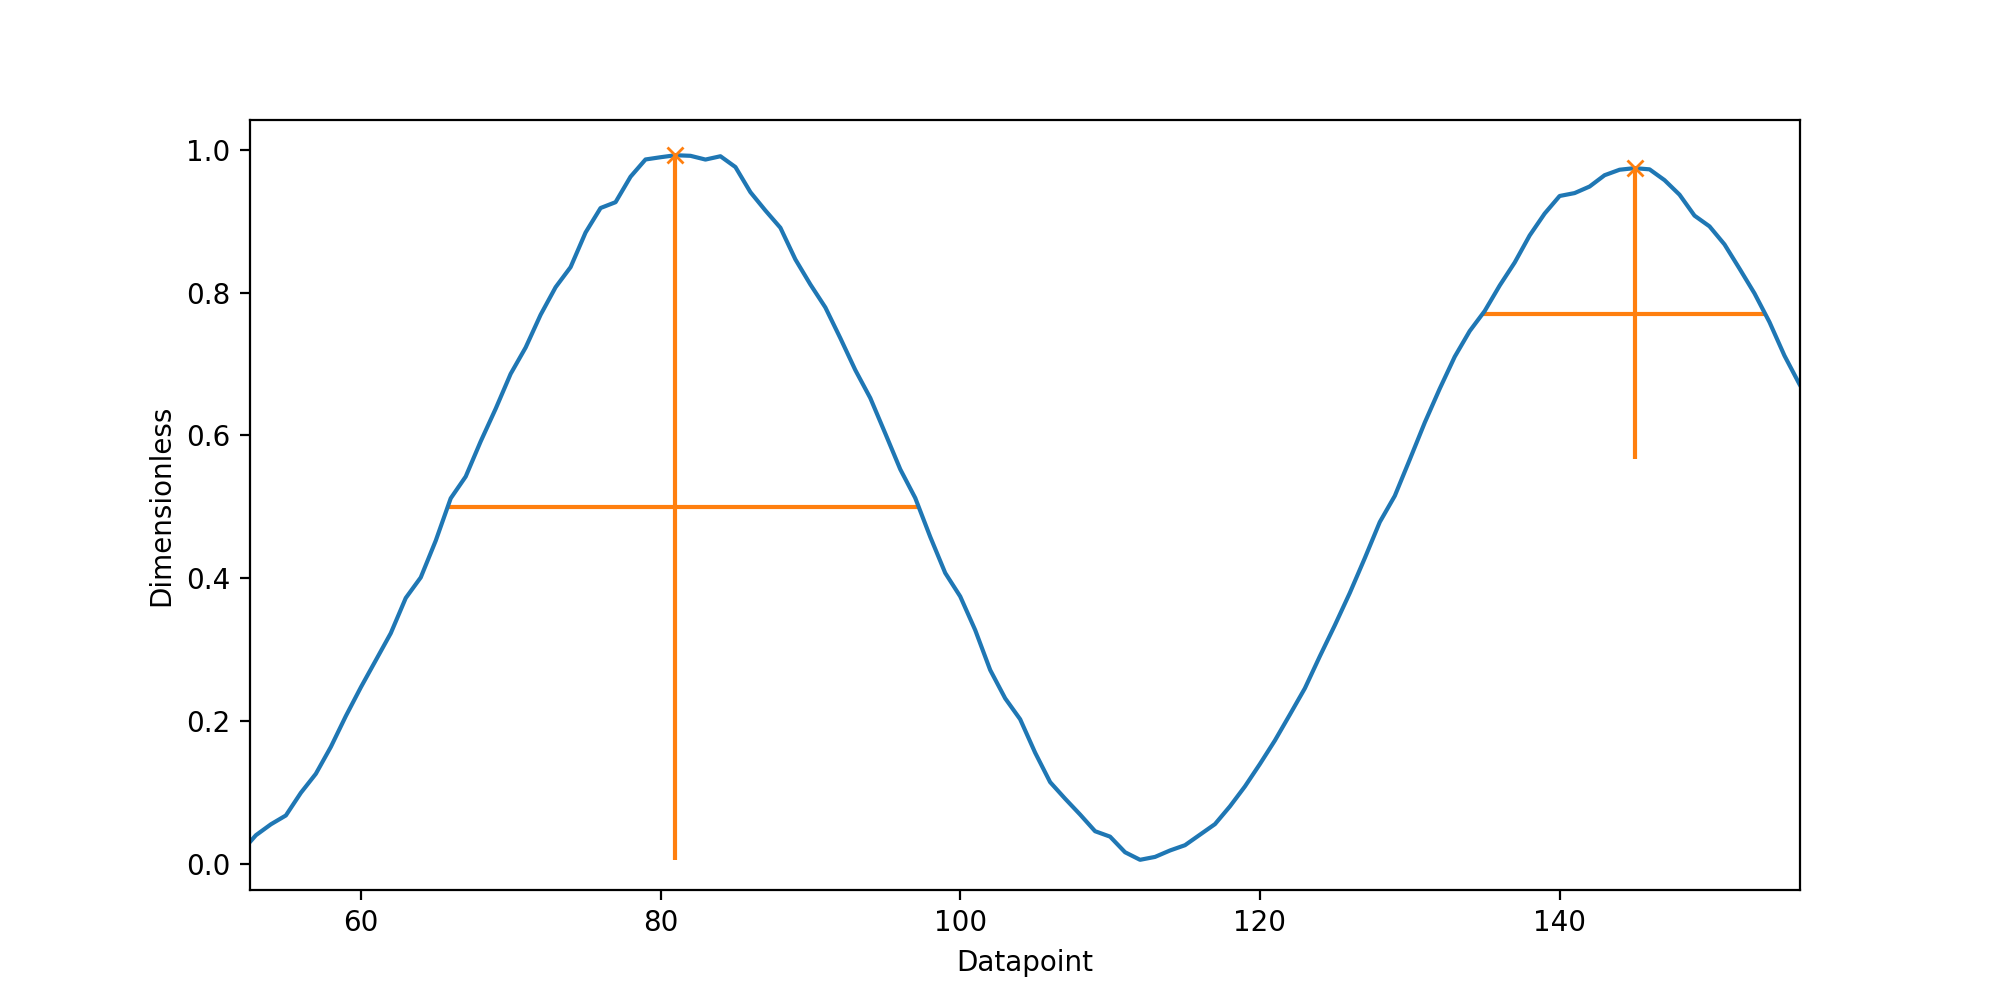

In [52]:
plt.figure(figsize=(10,5))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"], ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
plt.xlabel('Datapoint')
plt.ylabel('Dimensionless')
plt.show()

In [10]:
properties["widths"], properties["prominences"]

(array([  6.35782084,   7.67454707,   7.86037943,   7.84383121,
          7.7509141 ,   7.91520362,   7.5589096 ,   7.84855017,
          7.99690122,   7.77298863,   7.64917694,   7.86212842,
          7.87507222,   7.89632041,   8.19939052,   7.83903658,
          7.8086082 , 214.13700561,   8.07288656,  12.32163053,
          7.709128  ,   7.91178099]),
 array([0.31977114, 0.34841202, 0.37033389, 0.36977215, 0.35635644,
        0.38096076, 0.359512  , 0.36073195, 0.38307261, 0.3597214 ,
        0.35869189, 0.38558944, 0.36603044, 0.36782404, 0.39649413,
        0.3632204 , 0.36926398, 0.57272181, 0.18676786, 0.3558894 ,
        0.19357012, 0.18487057]))

In [11]:
import rrcf
from statistics import stdev, mean

# Set tree parameters
num_trees = 50
shingle_size = 1
tree_size = 256
codisp_threshold = 10
stdev_threshold = 3

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Use the "shingle" generator to create rolling window
points = rrcf.shingle(x, shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees
    if avg_codisp[index] > codisp_threshold:
        print("Anomaly detected!: ", avg_codisp[index], codisp_threshold, point)
    if index > 2 and mean(avg_codisp.values()) + stdev(avg_codisp.values()) * stdev_threshold < avg_codisp[index]:
        print("Anomaly detected via stdev!:", index, point)

Anomaly detected via stdev!: 62 [0.30850621]
Anomaly detected!:  16.879468253968252 10 [0.29686243]
Anomaly detected via stdev!: 93 [0.29686243]
Anomaly detected via stdev!: 114 [0.5602041]
Anomaly detected!:  13.446071136900922 10 [0.29480264]
Anomaly detected via stdev!: 156 [0.29480264]
Anomaly detected!:  14.364645223606681 10 [0.70790116]
Anomaly detected via stdev!: 227 [0.70790116]
Anomaly detected!:  87.87175980392156 10 [0.76321967]
Anomaly detected via stdev!: 274 [0.76321967]
Anomaly detected!:  86.68121008403362 10 [0.8151366]
Anomaly detected via stdev!: 275 [0.8151366]
Anomaly detected!:  66.50188888888889 10 [0.85333475]
Anomaly detected via stdev!: 276 [0.85333475]
Anomaly detected!:  54.39290141816458 10 [0.86752445]
Anomaly detected via stdev!: 277 [0.86752445]
Anomaly detected!:  37.47316938056069 10 [0.86752445]
Anomaly detected via stdev!: 278 [0.86752445]
Anomaly detected!:  29.232940758940757 10 [0.86752445]
Anomaly detected!:  24.13267845322706 10 [0.86752445]
A